# AlexNet
    2012年，AlexNet横空出世。它首次证明了学习到的特征可以超越手工设计的特征。它一举打破了计算机视觉研究的现状。 AlexNet使用了8层卷积神经网络，并以很大的优势赢得了2012年ImageNet图像识别挑战赛。
<img src="pic\19.jpg"  width="400"/>

AlexNet和LeNet的设计理念非常相似，但也存在显著差异。 首先，AlexNet比相对较小的LeNet5要深得多。 AlexNet由八层组成：五个卷积层、两个全连接隐藏层和一个全连接输出层。 其次，AlexNet使用ReLU而不是sigmoid作为其激活函数。

## 主要改进
* 丢弃法
* ReLu
* MaxPooling

## 模型设计
在AlexNet的第一层，卷积窗口的形状是11x11。 由于ImageNet中大多数图像的宽和高比MNIST图像的多10倍以上，因此，需要一个更大的卷积窗口来捕获目标。 第二层中的卷积窗口形状被缩减为5x5，然后是3x3。 此外，在第一层、第二层和第五层卷积层之后，加入窗口形状为3x3、步幅为2的最大汇聚层。 而且，AlexNet的卷积通道数目是LeNet的10倍。

<img src="pic\20.jpg" width="500"/>
<img src="pic\21.jpg" width="500"/>

在最后一个卷积层后有两个全连接层，分别有4096个输出。 这两个巨大的全连接层拥有将近1GB的模型参数。 由于早期GPU显存有限，原版的AlexNet采用了双数据流设计，使得每个GPU只负责存储和计算模型的一半参数。 幸运的是，现在GPU显存相对充裕，所以我们现在很少需要跨GPU分解模型（因此，我们的AlexNet模型在这方面与原始论文稍有不同）。

<img src="pic\22.jpg" width="500"/>

## 激活函数
此外，AlexNet将sigmoid激活函数改为更简单的ReLU激活函数。 

一方面，ReLU激活函数的计算更简单，它不需要如sigmoid激活函数那般复杂的求幂运算。 

另一方面，当使用不同的参数初始化方法时，ReLU激活函数使训练模型更加容易。 

当sigmoid激活函数的输出非常接近于0或1时，这些区域的梯度几乎为0，因此反向传播无法继续更新一些模型参数。 相反，ReLU激活函数在正区间的梯度总是1。 因此，如果模型参数没有正确初始化，sigmoid函数可能在正区间内得到几乎为0的梯度，从而使模型无法得到有效的训练。
<img src="pic\23.jpg" width="500"/>

随机截取图像的一部分、亮度变大变小、随机调整色温。

In [1]:
import torch
from torchvision import transforms
from  torch.utils import data 
import torchvision
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

# 数据预处理


In [2]:
def load_data(batch_size,resize):
    # 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
    # 并除以255使得所有像素的数值均在0到1之间
    trans =[transforms.ToTensor()]
    #修改图片大小
    if resize:
        trans.insert(0,transforms.Resize(resize)) 
    trans=transforms.Compose(trans)
    #下载训练数据
    mnist_train = torchvision.datasets.FashionMNIST(
        root="datasets",  #保存的目录
        train=True,       #下载的是训练数据集
        transform=trans,   #得到的是pytorch的tensor，而不是图片
        download=True)  #从网上下载
    #下载测试数据
    mnist_test = torchvision.datasets.FashionMNIST(
        root="datasets", train=False, transform=trans, download=True)
    print(len(mnist_train),len(mnist_test))
    #装载数据
    data_loader_train=data.DataLoader(dataset=mnist_train,
                                                batch_size=batch_size,
                                                shuffle=True)   #数据是否打乱
    data_loader_test=data.DataLoader(dataset=mnist_test,
                                    batch_size=batch_size,
                                    shuffle=True)
    return data_loader_train,data_loader_test

In [3]:
def AlexNet():
    net=torch.nn.Sequential(
        #cnn1
        torch.nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3,stride=2),
        #cnn2
        torch.nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,padding=2),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3,stride=2), 
        # 使用三个连续的卷积层和较小的卷积窗口。
        # 除了最后的卷积层，输出通道的数量进一步增加。
        # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
        torch.nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3,stride=2),
        torch.nn.Flatten(),
        #这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
        torch.nn.Linear(6400,4096),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(4096,4096),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(4096,10)
    )
    return net

In [4]:
net=AlexNet()
x = torch.randn(1,1,224,224)
for layer in net:
    x=layer(x)
    print(layer.__class__.__name__,'output shape:\t',x.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6400 and 13150x4096)

# 读取数据
    尽管本文中AlexNet是在ImageNet上进行训练的，但我们在这里使用的是Fashion-MNIST数据集。因为即使在现代GPU上，训练ImageNet模型，同时使其收敛可能需要数小时或数天的时间。 将AlexNet直接应用于Fashion-MNIST的一个问题是，Fashion-MNIST图像的分辨率（28x28像素）低于ImageNet图像。 为了解决这个问题，我们将它们增加到224x224（通常来讲这不是一个明智的做法，但我们在这里这样做是为了有效使用AlexNet架构）。 我们使用d2l.load_data_fashion_mnist函数中的resize参数执行此调整。

60000 10000
torch.Size([64, 1, 224, 224])
torch.Size([224, 224])


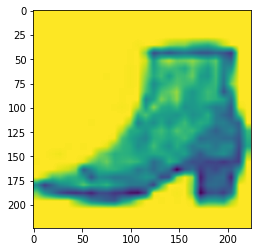

In [ ]:
train_iter,test_iter=load_data(batch_size=64,resize=224)
for x,y in train_iter:
    print(x.shape)
    print(x[0][0].shape)
    pic1=Image.fromarray(np.uint8(255 -x[0][0]* 255))
    plt.imshow(pic1)
    break
#一个batch_size中由64个样本，通道数是1，维度是28*28

# 训练AlexNet
    现在，我们可以开始训练AlexNet了。与LeNet相比，这里的主要变化是使用更小的学习速率训练，这是因为网络更深更广、图像分辨率更高，训练卷积神经网络就更昂贵。

In [ ]:
'''定义预测准确率函数'''
def acc(y_hat,y):
    '''
    :param y_hat: 接收二维张量，例如 torch.tensor([[1], [0]...])
    :param y: 接收二维张量，例如 torch.tensor([[0.1, 0.2, 0.7], [0.8, 0.1, 0.1]...]) 三分类问题
    :return:
    '''
    y_hat=y_hat.argmax(axis=1)
    cmp=y_hat.type(y.dtype)==y  #数据类型是否相同
    return float(cmp.type(y.dtype).sum())
    
class Accumulator():
    ''' 对评估的正确数量和总数进行累加 '''
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, item):
        return self.data[item]

'''自定义每个批次训练函数'''
def train_epoch(net,train_iter,loss,optimizer,device):
    #判断是不是pytorch得model，如果是，就打开训练模式，pytorch得训练模式默认开启梯度更新
    if isinstance(net,torch.nn.Module):
        net.train()
    #创建样本累加器【累加每批次的损失值、样本预测正确的个数、样本总数】
    metric = Accumulator(3)  
    for x,y in train_iter:
        x=x.to(device)                            #<----------------------GPU
        y=y.to(device)
        #前向传播获取预测结果
        y_hat=net(x)
        #计算损失
        l=loss(y_hat,y) 
        #判断是pytorch自带得方法还是我们手写得方法（根据不同得方法有不同得处理方式）
        if isinstance(optimizer,torch.optim.Optimizer):
            #梯度清零
            optimizer.zero_grad()
            #损失之求和，反向传播（pytorch自动进行了损失值计算）
            l.backward()
            #更新梯度
            optimizer.step()
            #累加个参数
            metric.add(
                float(l)*len(y),  #损失值总数
                acc(y_hat,y),     #计算预测正确得总数
                y.size().numel()  #样本总数
            )
    #返回平均损失值，预测正确得概率
    return metric[0]/metric[2],metric[1]/metric[2]

'''模型测试'''
def test_epoch(net,test_iter,device):
    if isinstance(net,torch.nn.Module):
        net.eval()  #将模型设置为评估模式
    metric=Accumulator(2)
    for x,y in test_iter:
        x=x.to(device)                            #<----------------------GPU
        y=y.to(device)
        metric.add(
            acc(net.forward(x),y),  #计算准确个数
            y.numel()  #测试样本总数
        )
    return metric[0]/metric[1]

'''正式训练'''
def train_LeNet(num_epochs,trian_iter,test_iter,lr):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    net=AlexNet()
    net=net.to(device)  #将网络放在gpu或cpu运行<--------------
    loss_list=[]
    train_acc=[]
    test_acc=[]
    #初始化权重
    def init_weight(m):
        if type(m)==torch.nn.Linear or type(m)==torch.nn.Conv2d:
            torch.nn.init.xavier_normal_(m.weight)
    net.apply(init_weight)
    #损失函数
    loss=torch.nn.CrossEntropyLoss()
    #优化器
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    #训练
    for epoch in range(num_epochs):
        #返回平均损失值和正确率
        train_metrics=train_epoch(net,trian_iter,loss,optimizer,device)  #<-----训练
        loss_list.append(train_metrics[0])  #保存loss
        train_acc.append(train_metrics[1])   #保存准确率
        #测试集
        test_metric=test_epoch(net,test_iter,device)     #<-------------测试
        test_acc.append(test_metric)
        print(f"epoch{epoch+1}:loss={train_metrics[0]},train_acc={train_metrics[1]*100:.2f}%,test_acc={test_metric*100:.2f}%")
    
    return loss_list,train_acc,test_acc

'''可视化'''
def draw(num_epochs,loss_list,train_acc,test_acc):
    fig,ax=plt.subplots()   #定义画布
    ax.grid(True)          #添加网格
    ax.set_xlabel("epoch")
    #ax.set_ylim(0,1)

    ax.plot(range(num_epochs),loss_list,label="loss")
    ax.plot(range(num_epochs),train_acc,dashes=[6, 2],label="train")
    ax.plot(range(num_epochs),test_acc,dashes=[6, 2],label="test")
    ax.legend()
    plt.show()

In [ ]:
batch_size=64
num_epochs=10
lr=0.01
#数据集
train_iter,test_iter=load_data(batch_size=64,resize=224)
#训练
loss_list,train_acc,test_acc=train_LeNet(num_epochs,train_iter,test_iter,lr)

60000 10000
cpu


KeyboardInterrupt: 

In [ ]:
'''删除jpyter缓存'''
import os
import shutil

for root,dirs,files in os.walk('./'):
    root_silit=root.split('\\')
    if '__pycache__' in root_silit or '.ipynb_checkpoints' in root_silit:
        print('删除：',root)
        shutil.rmtree(root)